# Clustering Analysis Lecture

In this lecture, we'll cover unsupervised learning techniques for clustering. We will explore:

- **K-Means Clustering** with the Elbow Method for choosing the optimal number of clusters.
- **DBSCAN** for density-based clustering.
- **Hierarchical Clustering** using various linkage methods (single, complete, average, Ward).
- **Agglomerative Clustering** with visualization of clusters.

We will use synthetic datasets (from `sklearn.datasets`) and a real-world dataset (Mall_Customers) for demonstration.


In [62]:
# Import Libraries and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
import scipy.cluster.hierarchy as sch

# Set plotting style
sns.set(style="whitegrid")
%matplotlib inline


## K-Means Clustering

We will first generate a synthetic dataset using `make_blobs` and apply K-Means clustering.

1- Randomly select centroids (center of cluster) for each cluster.

2- Calculate the distance of all data points to the centroids.

3- Assign data points to the closest cluster.

4- Find the new centroids of each cluster by taking the mean of all data points in the cluster.

5- Repeat steps 2,3 and 4 until all points converge and cluster centers stop moving.

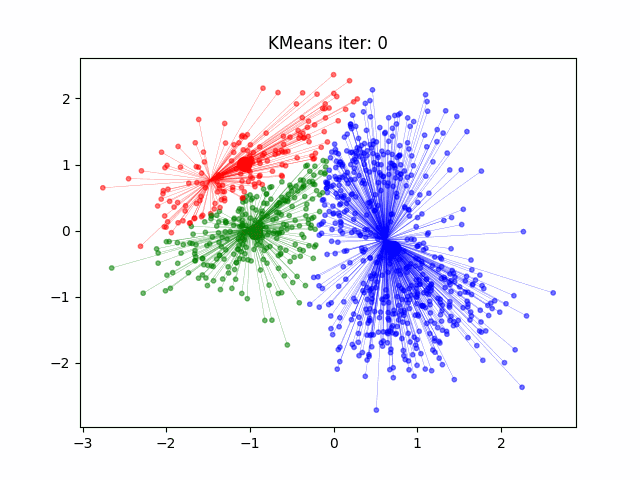

In [63]:
# Cell: Display K-Means Animation GIF
from IPython.display import Image, display

# Display the GIF (ensure 'kmeans.gif' is uploaded to your Colab environment)
display(Image("/content/sample_data/kmeans.gif"))


## Distance Metrics

For clustering, understanding various distance metrics is essential because they determine how similarity between data points is computed. Here are some common metrics:

### Euclidean Distance
The Euclidean distance is the "ordinary" straight-line distance between two points in Euclidean space.
$$ d_E(A,B) = \sqrt{\sum_{i=1}^{n}(A_i - B_i)^2} $$

### Manhattan Distance
Also known as the L1 norm, it sums the absolute differences of the coordinates.
$$ d_M(A,B) = \sum_{i=1}^{n}|A_i - B_i| $$

### Minkowski Distance
A generalization of Euclidean and Manhattan distances. For \(p=1\) it equals Manhattan distance; for \(p=2\) it equals Euclidean distance.
$$ d_{Minkowski}(A,B) = \left(\sum_{i=1}^{n}|A_i - B_i|^p \right)^{\frac{1}{p}} $$

### Chebyshev Distance
Measures the greatest absolute difference along any coordinate dimension.
$$ d_C(A,B) = \max_{i=1,\dots,n}|A_i - B_i| $$

### Cosine Distance
Based on the cosine similarity, which measures the cosine of the angle between two vectors. Cosine distance is defined as:
$$ \text{Cosine Similarity}(A,B) = \frac{A \cdot B}{\|A\|\|B\|} $$
$$ d_{cos}(A,B) = 1 - \text{Cosine Similarity}(A,B) $$

Below is a Python snippet that computes these distance metrics using NumPy.


In [64]:
# Compute Distance Metrics using NumPy

import numpy as np

def euclidean_distance(A, B):
    return np.sqrt(np.sum((A - B) ** 2))

def manhattan_distance(A, B):
    return np.sum(np.abs(A - B))

def minkowski_distance(A, B, p):
    return np.power(np.sum(np.abs(A - B) ** p), 1/p)

def chebyshev_distance(A, B):
    return np.max(np.abs(A - B))

def cosine_similarity(A, B):
    return np.dot(A, B) / (np.linalg.norm(A) * np.linalg.norm(B))

def cosine_distance(A, B):
    return 1 - cosine_similarity(A, B)

# Example vectors
A = np.array([1, 2, 3])
B = np.array([4, 5, 6])

print("Euclidean Distance:", euclidean_distance(A, B))
print("Manhattan Distance:", manhattan_distance(A, B))
print("Minkowski Distance (p=3):", minkowski_distance(A, B, 3))
print("Chebyshev Distance:", chebyshev_distance(A, B))
print("Cosine Similarity:", cosine_similarity(A, B))
print("Cosine Distance:", cosine_distance(A, B))


Euclidean Distance: 5.196152422706632
Manhattan Distance: 9
Minkowski Distance (p=3): 4.3267487109222245
Chebyshev Distance: 3
Cosine Similarity: 0.9746318461970762
Cosine Distance: 0.025368153802923787


* **n_clusters**: the number of desired clusters

* **n_init**: run the k-means clustering algorithms 10 times independently with different random centroids to choose the final model as the one with the lowest SSE
        
* **max_iter**: maximum number of iterations for each run

* **tol**: tolerance regarding the changes in the within-cluster SSE to declare convergence

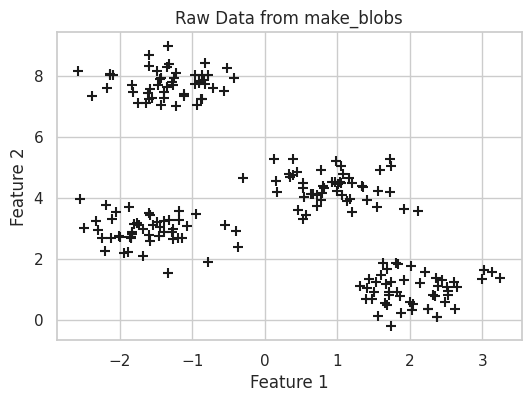

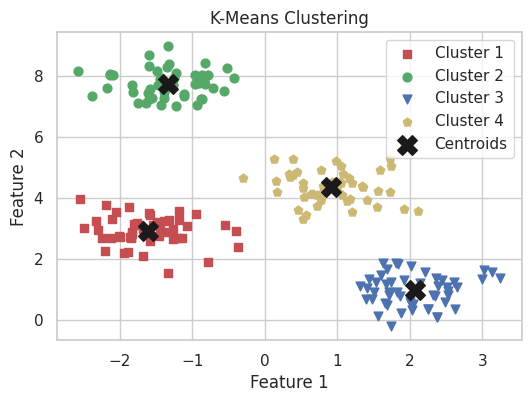

In [65]:
# Generate Synthetic Data using make_blobs and Apply K-Means
x, y_true = make_blobs(n_samples=200, n_features=2, centers=4, cluster_std=0.5,
                        shuffle=True, random_state=0)

# Visualize the raw data
plt.figure(figsize=(6,4))
plt.scatter(x[:, 0], x[:, 1], c='k', marker='+', s=50)
plt.title("Raw Data from make_blobs")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

# Apply K-Means clustering
km = KMeans(n_clusters=4, init='random', n_init=10, max_iter=100, tol=1e-4, random_state=0)
y_km = km.fit_predict(x)

# Plot clustered data with centroids
plt.figure(figsize=(6,4))
plt.scatter(x[y_km==0, 0], x[y_km==0, 1], s=40, c='r', marker='s', label='Cluster 1')
plt.scatter(x[y_km==1, 0], x[y_km==1, 1], s=40, c='g', marker='o', label='Cluster 2')
plt.scatter(x[y_km==2, 0], x[y_km==2, 1], s=40, c='b', marker='v', label='Cluster 3')
plt.scatter(x[y_km==3, 0], x[y_km==3, 1], s=40, c='y', marker='p', label='Cluster 4')
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], s=200, c='k', marker='X', label='Centroids')
plt.title("K-Means Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()


### The Elbow Method

The Elbow Method helps us choose the optimal number of clusters by plotting the within-cluster sum-of-squares (inertia) for different values of k.

**Theorem**: if k increases, the within-cluster SSE (“distortion”) will decrease.
    
**Inertia** is calculated by measuring the distance between each data point and its centroid.

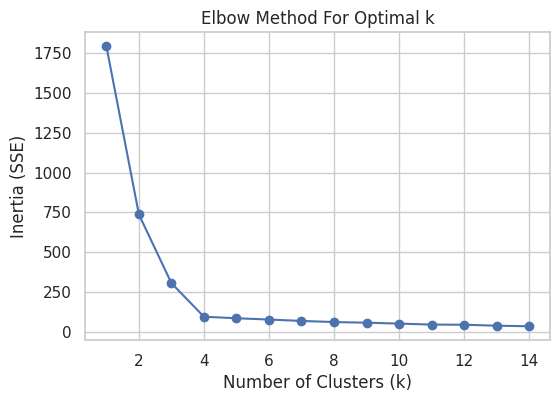

In [66]:
# The Elbow Method
inertias = []
for i in range(1, 15):
    km_temp = KMeans(n_clusters=i, init='random', n_init=10, max_iter=300, tol=1e-4, random_state=0)
    km_temp.fit(x)
    inertias.append(km_temp.inertia_)

plt.figure(figsize=(6,4))
plt.plot(range(1, 15), inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (SSE)')
plt.title('Elbow Method For Optimal k')
plt.show()


## DBSCAN Clustering

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) clusters points based on density and is well-suited for non-globular clusters.

We'll use a noisy dataset generated using `make_moons` or `make_circles`.


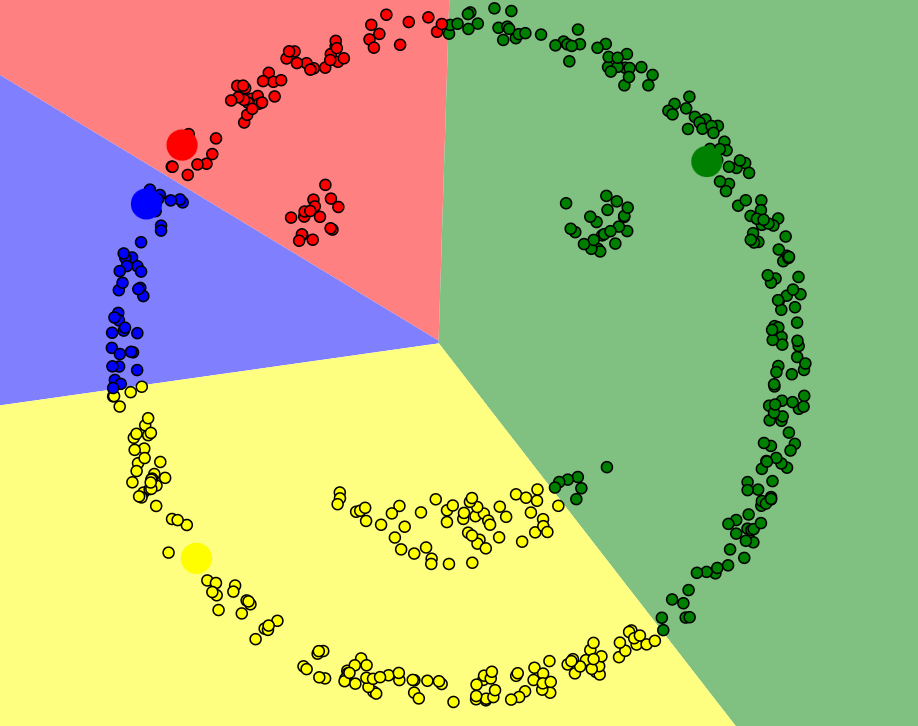

In [67]:
# Cell: Display sbscan Animation GIF
from IPython.display import Image, display

# Display the GIF (ensure 'dbscan.gif' is uploaded to your Colab environment)
display(Image("/content/sample_data/dbscan.gif", width=400, height=300))

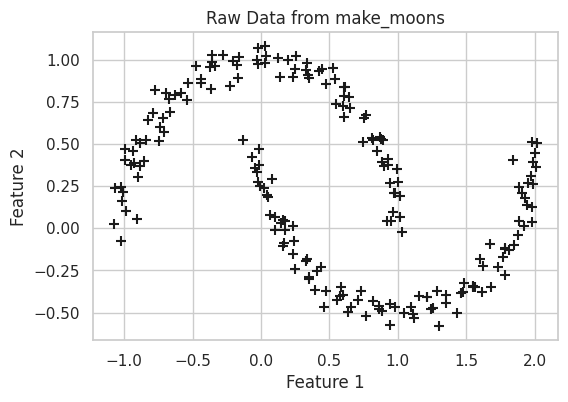

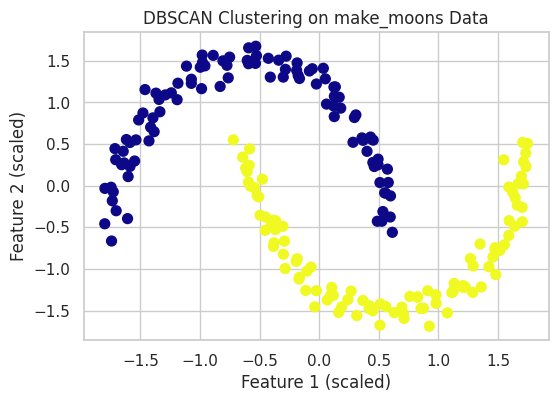

In [68]:
# DBSCAN on Noisy Data (using make_moons)
x_moons, y_moons = make_moons(n_samples=200, noise=0.05, shuffle=True, random_state=0)

plt.figure(figsize=(6,4))
plt.scatter(x_moons[:, 0], x_moons[:, 1], c='k', marker='+', s=50)
plt.title("Raw Data from make_moons")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

# Scale data (optional but recommended for DBSCAN)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_moons_scaled = scaler.fit_transform(x_moons)

# Apply DBSCAN
dbscan = DBSCAN(eps=0.35, min_samples=3)
y_dbscan = dbscan.fit_predict(x_moons_scaled)

plt.figure(figsize=(6,4))
plt.scatter(x_moons_scaled[:, 0], x_moons_scaled[:, 1], c=y_dbscan, cmap='plasma', s=50)
plt.title("DBSCAN Clustering on make_moons Data")
plt.xlabel("Feature 1 (scaled)")
plt.ylabel("Feature 2 (scaled)")
plt.show()


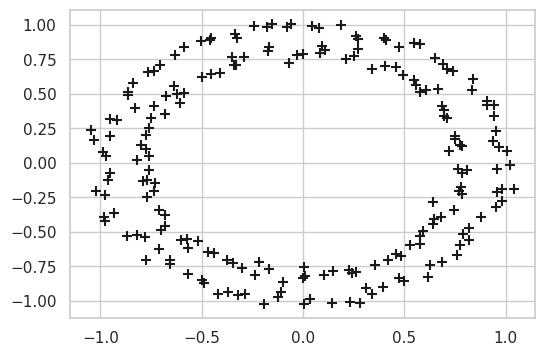

In [69]:
from sklearn.datasets import make_circles

x, y = make_circles(n_samples=200, noise=0.03, shuffle=True, random_state=0)

plt.figure(figsize=(6,4))
plt.scatter(x[:, 0], x[:, 1], c='k', marker='+', s=50)
plt.show()

## Hierarchical Clustering

Hierarchical clustering creates a dendrogram to show the merging or splitting of clusters. We'll use the Mall_Customers dataset (a common real-world example) to demonstrate.


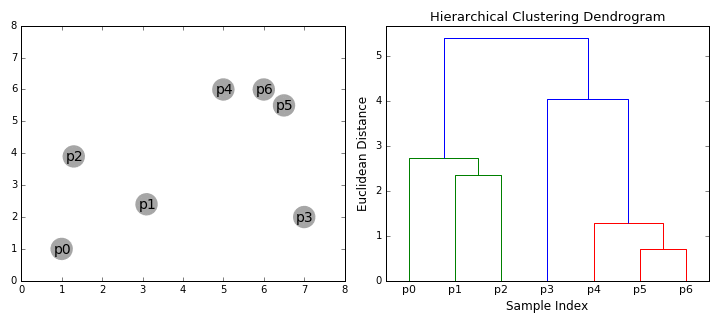

In [70]:
# Cell: Display Hierarch Animation GIF
from IPython.display import Image, display

# Display the GIF (ensure 'hierarch.gif' is uploaded to your Colab environment)
display(Image("/content/sample_data/hierarch.gif"))

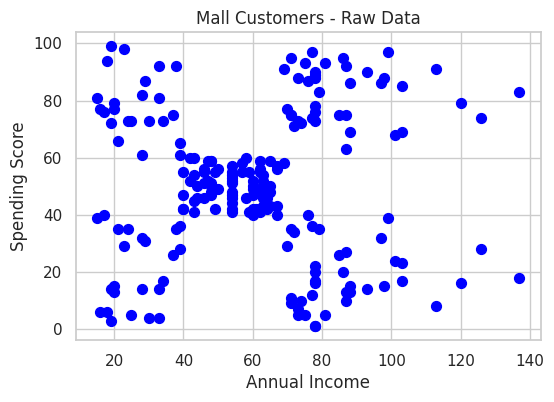

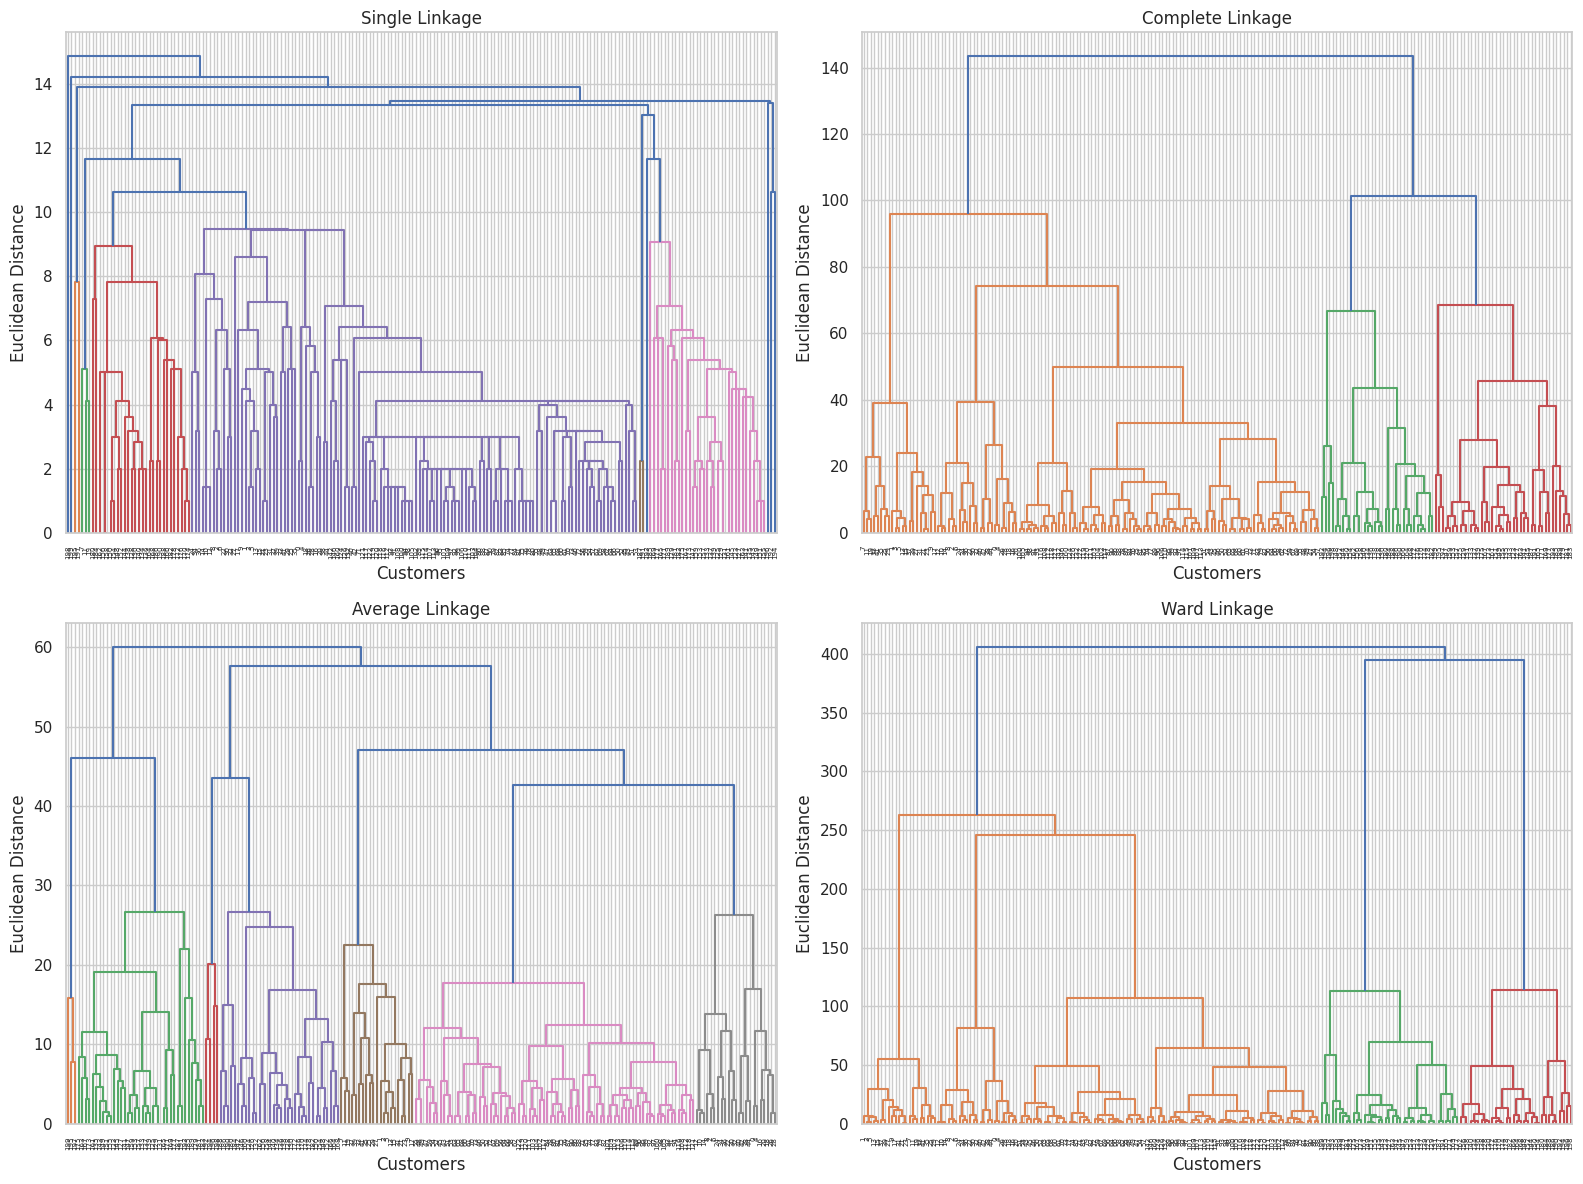

In [71]:
# Hierarchical Clustering using Mall_Customers Data
# Ensure you have 'Mall_Customers.csv' uploaded to Colab
df_mall = pd.read_csv('/content/sample_data/Mall_Customers.csv')

# For simplicity, use only two features (e.g., Annual Income and Spending Score)
x_mall = df_mall.iloc[:, [3, 4]].values  # Adjust column indices based on your dataset

# Plot the raw data
plt.figure(figsize=(6,4))
plt.scatter(x_mall[:, 0], x_mall[:, 1], c='blue', s=50)
plt.title("Mall Customers - Raw Data")
plt.xlabel("Annual Income")
plt.ylabel("Spending Score")
plt.show()

# Generate and plot dendrograms for different linkage methods
linkage_methods = ['single', 'complete', 'average', 'ward']
plt.figure(figsize=(16, 12))
for i, method in enumerate(linkage_methods, 1):
    plt.subplot(2, 2, i)
    dendrogram = sch.dendrogram(sch.linkage(x_mall, method=method))
    plt.title(f"{method.capitalize()} Linkage")
    plt.xlabel("Customers")
    plt.ylabel("Euclidean Distance")
plt.tight_layout()
plt.show()


## Agglomerative Clustering

Agglomerative clustering is a bottom-up approach that builds clusters by merging the closest pairs iteratively.


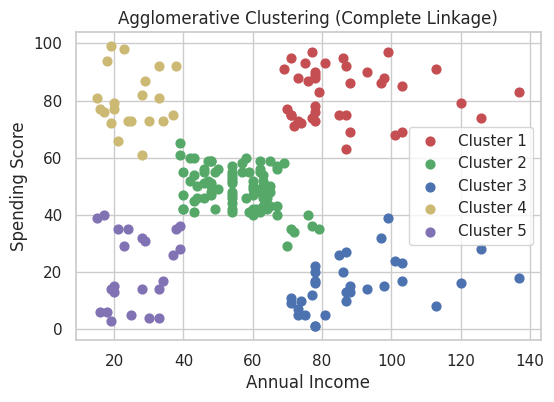

In [72]:
# Agglomerative Clustering on Mall_Customers Data
ac = AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='complete')
y_ac = ac.fit_predict(x_mall)

plt.figure(figsize=(6,4))
colors = ['r', 'g', 'b', 'y', 'm']
for cluster in range(5):
    plt.scatter(x_mall[y_ac == cluster, 0], x_mall[y_ac == cluster, 1],
                s=40, c=colors[cluster], label=f'Cluster {cluster+1}')
plt.title("Agglomerative Clustering (Complete Linkage)")
plt.xlabel("Annual Income")
plt.ylabel("Spending Score")
plt.legend()
plt.show()

## Summary

In this lecture, we explored various clustering techniques:
- **K-Means Clustering**: We used synthetic data from `make_blobs`, visualized clusters and centroids, and applied the Elbow Method to determine the optimal number of clusters.
- **DBSCAN**: We applied density-based clustering on a noisy dataset (using `make_moons`), and visualized the results.
- **Hierarchical Clustering**: We generated dendrograms using different linkage methods on the Mall_Customers dataset.
- **Agglomerative Clustering**: We clustered customers based on annual income and spending score.
- **Distance Metrics**: We reviewed Euclidean and Minkowski distance formulas.

For further details, refer to:
- [Stanford Clustering Lecture](http://infolab.stanford.edu/~ullman/mmds/ch7.pdf)
- [scikit-learn Clustering Documentation](https://scikit-learn.org/stable/modules/clustering.html)
- [Matplotlib Gallery](https://matplotlib.org/stable/gallery/index.html)
- [Seaborn Documentation](https://seaborn.pydata.org/)

Happy clustering!